### Задача 2: на основе данных выявить поведенчиские шаблоны пьющих и непьющих студентов, можно делать в Jupyter notebook  

In [246]:
import seaborn as sns
import numpy as np
import pandas as pd
import itertools

import statsmodels
import scipy as sc
from statsmodels.graphics.regressionplots import plot_leverage_resid2
import matplotlib.pyplot as plt

In [24]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [22]:
#Loading and checking data
df = pd.read_csv("data/student-mat.csv", sep=";")
print(" data shape: ", df.shape, "\n rows with NA values: ", df.isnull().any(axis=1).sum())
df.head(1)

 data shape:  (395, 33) 
 rows with NA values:  0


,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,6,5,6,6


In [288]:
numeric = ["age", 'Medu', "Fedu", "traveltime", "studytime", "failures",\
           "famrel", "freetime", "goout", "Dalc", "Walc", "health", "absences", "G1", "G2", "G3"]

categorical = ["address", "famsize", "Pstatus", "schoolsup", "famsup", "paid",
          "activities", "nursery", "higher", "internet", "romantic",
              'school', 'sex', 'Mjob', 'Fjob', 'guardian']

In [289]:
len(categorical), len(numeric)

(16, 16)

## Мы хотим посмотреть на связь между потреблением алкоголя и другими признаками

In [143]:
#Как выглядит распределение по возрасту
pd.crosstab(df["sex"],df["age"])

age,15,16,17,18,19,20,21,22
sex,,,,,,,,
F,38,54,58,43,14,1,0,0
M,44,50,40,39,10,2,1,1


In [144]:
#Ребят старше 19 лет можно смело выкинуть
labels = df[df["age"] > 19].index
df = df.drop(labels=labels)

### Как выглядит потребление студентами алкоголя?

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe68ff406d8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7fe68e884978>]], dtype=object)

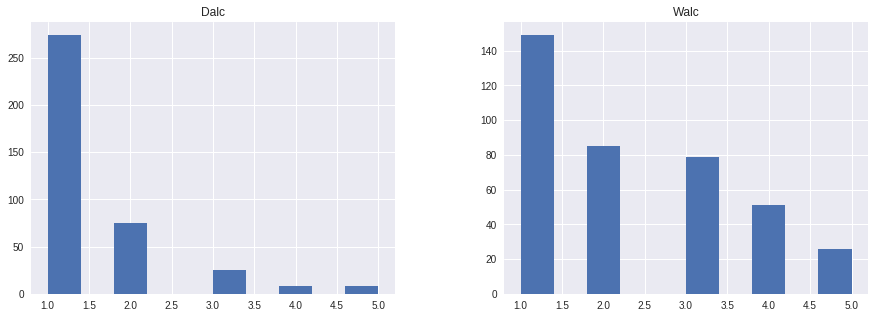

In [146]:
alc = ["Dalc", "Walc"]
df.hist(column=alc, figsize=(15, 5))

In [156]:
df['Dalc'].value_counts()

1    274
2     75
3     25
5      8
4      8
Name: Dalc, dtype: int64

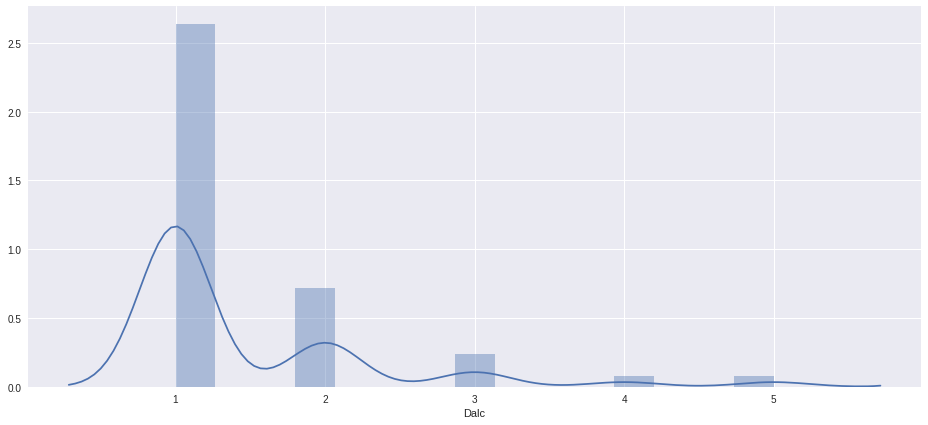

In [154]:
#распределение Dalc сильно скошено в сторону маленьких значений, посмотрим на связь Dalc и Walc
sns.distplot(df['Dalc'])

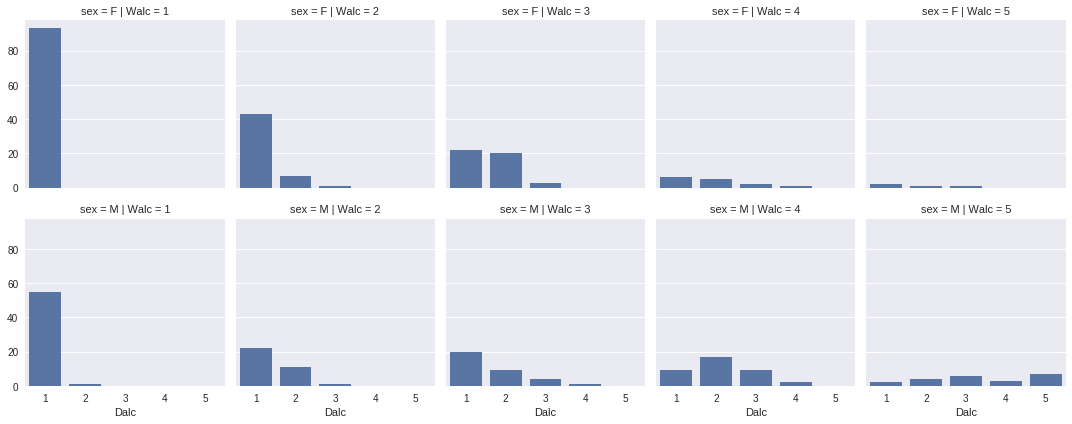

In [172]:
g = sns.FacetGrid(df, col='Walc', row="sex")
g.map(sns.countplot, "Dalc")
sns.plt.show()

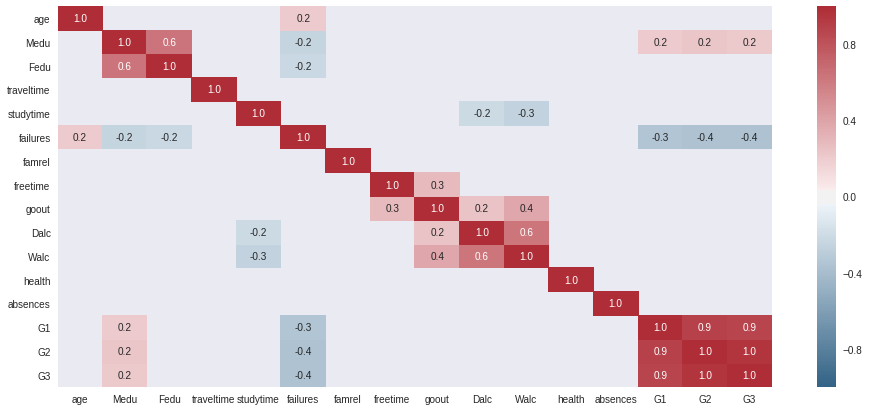

In [173]:
cmap = sns.diverging_palette(240, 10, s=75, l=40, as_cmap=True)
mask = df[numeric].corr(method="spearman").abs() < 0.2
ax = sns.heatmap(df[numeric].corr(method="spearman"), cmap=cmap, mask=mask,
                annot=True, fmt=".1f")

Посмотрим на матрицу диаграмм рассеяния по количественным признакам:

In [306]:
#Посчитаем коэффициенты V Крамера
from scipy.stats import chi2_contingency
from statsmodels.sandbox.stats.multicomp import multipletests 
chi2_test = pd.DataFrame(columns=['first', 'second', 'cramer_v', 'pvalue'])

for ind, (f, s) in enumerate(itertools.combinations(categorical, 2)):   
    data = pd.crosstab(df[f],df[s])
    
    chi2, pvalue = chi2_contingency(data)[:2]
    n, dim = data.as_matrix().sum(), min(data.shape) - 1
    cramer_v = np.sqrt(chi2 / n / dim)
    
    chi2_test.loc[ind] = [f, s, cramer_v, pvalue]

#Введём поправку на множетсвенное тестирование методом холма
reject, p_corrected, a1, a2 = multipletests(chi2_test.pvalue, 
                                            alpha = 0.05, 
                                            method = 'holm')
chi2_test['p_corrected'] = p_corrected
chi2_test['reject'] = reject

#Посмотрим что получили
print("H rejected without multiple tsting correction:", (chi2_test.pvalue <= 0.05).sum())
print("H rejected with multiple tsting correction:", (chi2_test.p_corrected <= 0.05).sum())
chi2_test[chi2_test.reject == True]

H rejected without multiple tsting correction: 23
H rejected with multiple tsting correction: 5


,first,second,cramer_v,pvalue,p_corrected,reject
8,address,internet,0.208293,3.897773e-05,4.521417e-03,True
10,address,school,0.273489,6.628007e-08,7.821048e-06,True
54,famsup,paid,0.278652,3.734998e-08,4.444648e-06,True
102,internet,Mjob,0.279665,3.866161e-06,4.523408e-04,True
117,Mjob,Fjob,0.214797,4.487963e-09,5.385555e-07,True


In [307]:
chi2_test[chi2_test.pvalue <= 0.05]

,first,second,cramer_v,pvalue,p_corrected,reject
8,address,internet,0.208293,3.897773e-05,4.521417e-03,True
10,address,school,0.273489,6.628007e-08,7.821048e-06,True
12,address,Mjob,0.179309,1.376162e-02,1.000000e+00,False
15,famsize,Pstatus,0.135654,7.385365e-03,8.050048e-01,False
17,famsize,famsup,0.116628,2.126698e-02,1.000000e+00,False
49,schoolsup,school,0.124397,1.402379e-02,1.000000e+00,False
50,schoolsup,sex,0.128480,1.117174e-02,1.000000e+00,False
54,famsup,paid,0.278652,3.734998e-08,4.444648e-06,True
60,famsup,school,0.167626,9.318142e-04,1.062268e-01,False
61,famsup,sex,0.138511,6.231032e-03,6.854135e-01,False


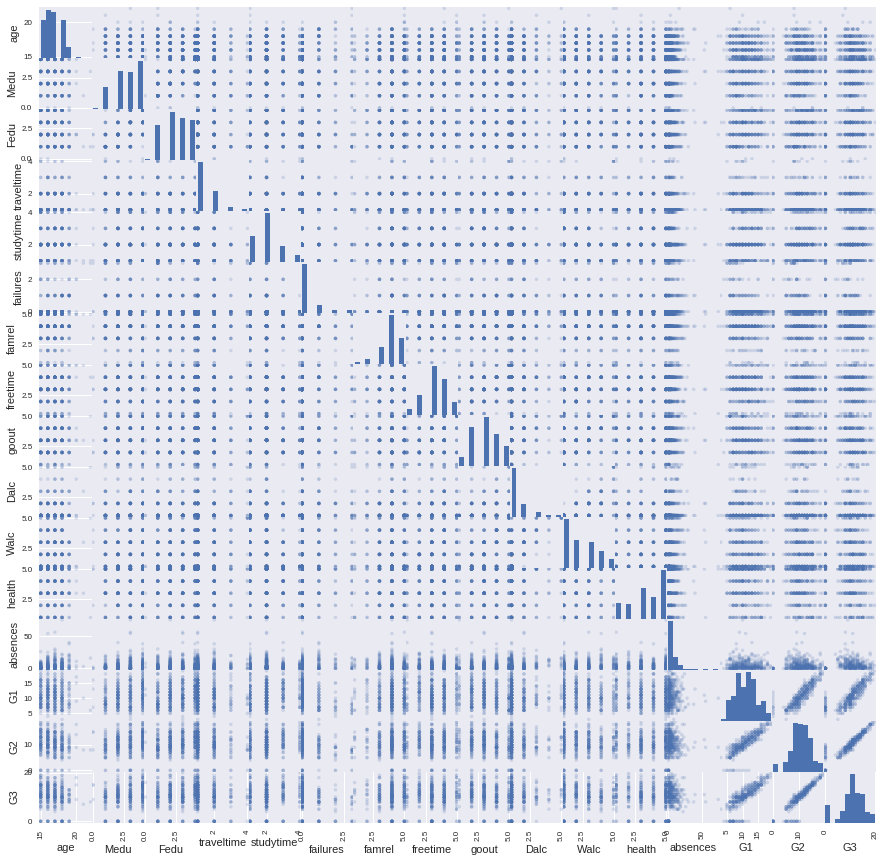

In [53]:
pd.plotting.scatter_matrix(df[numeric], alpha=0.2, 
                                 figsize=(15, 15), diagonal='hist')
pylab.show()

In [50]:
#Посмотрим на сбалансированность выборки
for col in categorical:
    print(col)
    print(df[col].value_counts(), "\n")

school
GP    349
MS     46
Name: school, dtype: int64 

sex
F    208
M    187
Name: sex, dtype: int64 

address
U    307
R     88
Name: address, dtype: int64 

famsize
GT3    281
LE3    114
Name: famsize, dtype: int64 

Pstatus
T    354
A     41
Name: Pstatus, dtype: int64 

Mjob
other       141
services    103
at_home      59
teacher      58
health       34
Name: Mjob, dtype: int64 

Fjob
other       217
services    111
teacher      29
at_home      20
health       18
Name: Fjob, dtype: int64 

reason
course        145
home          109
reputation    105
other          36
Name: reason, dtype: int64 

guardian
mother    273
father     90
other      32
Name: guardian, dtype: int64 

schoolsup
no     344
yes     51
Name: schoolsup, dtype: int64 

famsup
yes    242
no     153
Name: famsup, dtype: int64 

paid
no     214
yes    181
Name: paid, dtype: int64 

activities
yes    201
no     194
Name: activities, dtype: int64 

nursery
yes    314
no      81
Name: nursery, dtype: int64 

higher
y